In [1]:
import sys
sys.path.insert(0, '../../../network')

In [2]:
import logging
import argparse
import numpy as np
from network import Population, RateNetwork
from learning import ReachingTask
from transfer_functions import ErrorFunction
from connectivity import SparseConnectivity, LinearSynapse, ThresholdPlasticityRule
from sequences import GaussianSequence
import matplotlib.pyplot as plt
import seaborn as sns
logging.basicConfig(level=logging.INFO)

In [3]:
phi = ErrorFunction(mu=0.22, sigma=0.1).phi
ctx = Population(N=1000, tau=1e-2, phi=phi, name='ctx')
bg = Population(N=1000, tau=1e-2, phi=phi, name='bg')
plasticity = ThresholdPlasticityRule(x_f=0.5, q_f=0.8) 

S, P = 1, 3
sequences_ctx = [GaussianSequence(P,ctx.size, seed=114) for i in range(S)]
patterns_ctx = np.stack([s.inputs for s in sequences_ctx])
sequences_bg = [GaussianSequence(P,ctx.size, seed=29) for i in range(S)]
patterns_bg = np.stack([s.inputs for s in sequences_bg])

J_cc = SparseConnectivity(source=ctx, target=ctx, p=0.05)
synapse_cc = LinearSynapse(J_cc.K, A=5)
J_cc.store_attractors(patterns_ctx[0], patterns_ctx[0], synapse_cc.h_EE, 
                      plasticity.f, plasticity.g)
J_bb = SparseConnectivity(source=bg, target=bg, p=0.05)
synapse_bb = LinearSynapse(J_bb.K, A=5)
J_bb.store_attractors(patterns_bg[0], patterns_bg[0], synapse_bb.h_EE, 
                      plasticity.f, plasticity.g)
J_cb  = SparseConnectivity(source=bg, target=ctx, p=0.05)
synapse_cb = LinearSynapse(J_cb.K, A=1)
J_cb.store_attractors(patterns_bg[0], patterns_ctx[0], synapse_cb.h_EE, 
                      plasticity.f, plasticity.g)

J_bc = SparseConnectivity(source=ctx, target=bg, p=0.05)
synapse_bc = LinearSynapse(J_bc.K, A=0)
J_bc.store_sequences(patterns_ctx, patterns_bg, synapse_bc.h_EE, plasticity.f, plasticity.g)
# J_bc.update_sequences(patterns_ctx[0][0], patterns_bg[0][1],
#                    .7, lamb=1,f=plasticity.f, g=plasticity.g)
# J_bc.update_sequences(patterns_ctx[0][1], patterns_bg[0][2],
#                    .8, lamb=1,f=plasticity.f, g=plasticity.g)
# J_bc.update_sequences(patterns_ctx[0][2], patterns_bg[0][0],
#                    .7, lamb=1,f=plasticity.f, g=plasticity.g)

net_ctx = RateNetwork(ctx, c_EE=J_cc, c_IE=J_bc, formulation=4)
net_bg = RateNetwork(bg, c_II=J_bb, c_EI=J_cb, formulation=4)

INFO:connectivity:Building connections from ctx to ctx
INFO:connectivity:Storing attractors
100%|██████████████████████████████████████████| 1000/1000 [00:00<00:00, 18797.66it/s]
INFO:connectivity:Building connections from bg to bg
INFO:connectivity:Storing attractors
100%|██████████████████████████████████████████| 1000/1000 [00:00<00:00, 20898.69it/s]
INFO:connectivity:Building connections from bg to ctx
INFO:connectivity:Storing attractors
100%|██████████████████████████████████████████| 1000/1000 [00:00<00:00, 21588.41it/s]
INFO:connectivity:Building connections from ctx to bg
INFO:connectivity:Storing sequences
100%|███████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.58it/s]
INFO:connectivity:Applying synaptic transfer function
INFO:connectivity:Building sparse matrix


In [4]:
init_input_ctx = np.random.RandomState().normal(0,1,size=patterns_ctx[0][0].shape)
init_input_bg = np.random.RandomState().normal(0,1,size=patterns_bg[0][0].shape)
# init_input_ctx = patterns_ctx[0][0]
# init_input_bg = patterns_bg[0][0]
T=40
mouse = ReachingTask(3, alpha=0.5)
# net_ctx.simulate_learning(mouse, net_bg, T, init_input_ctx, init_input_bg, 
#                           phi(patterns_ctx[0]), phi(patterns_bg[0]), plasticity, detection_thres=.23)
net_ctx.simulate_learning(mouse, net_bg, T, init_input_ctx, init_input_bg, 
                          patterns_ctx[0], patterns_bg[0], plasticity, detection_thres=.23)

INFO:network:Integrating network dynamics
  0%|▏                                            | 124/39999 [00:02<08:57, 74.21it/s]

null-->aim


  1%|▌                                           | 549/39999 [00:03<01:25, 460.85it/s]

None 0


  2%|▋                                           | 609/39999 [00:03<02:08, 306.29it/s]

[-1, -1] 17


  2%|▊                                            | 690/39999 [00:06<11:15, 58.23it/s]

[0, -1] 68


  2%|▊                                            | 765/39999 [00:09<18:30, 35.33it/s]

aim-->reach


  3%|█▎                                          | 1198/39999 [00:26<25:20, 25.52it/s]

[0, 1] 504


  3%|█▍                                          | 1357/39999 [00:32<25:27, 25.29it/s]

[0, -1] 157


  3%|█▍                                          | 1363/39999 [00:32<25:35, 25.17it/s]

[0, 0] 7
[-1, 0] 3


  4%|█▌                                          | 1462/39999 [00:36<25:10, 25.52it/s]

reach-->aim


  5%|██                                          | 1861/39999 [00:52<25:29, 24.94it/s]

[1, 0] 493


  5%|██▏                                         | 2023/39999 [00:59<25:05, 25.22it/s]

[1, -1] 159


  5%|██▎                                         | 2059/39999 [01:00<24:47, 25.50it/s]

[1, 0] 35
[-1, 0] 2


  6%|██▊                                         | 2527/39999 [01:19<24:31, 25.47it/s]

[0, 0] 466


  7%|███                                         | 2737/39999 [01:27<24:43, 25.12it/s]

[0, -1] 208
[0, 0] 1


  7%|███                                         | 2746/39999 [01:27<25:11, 24.65it/s]

[0, -1] 5
[0, 0] 2


  7%|███                                         | 2791/39999 [01:29<24:35, 25.21it/s]

[0, -1] 42
[0, 0] 0


  7%|███                                         | 2800/39999 [01:30<24:43, 25.07it/s]

[0, -1] 7
[0, 0] 0


  7%|███                                         | 2809/39999 [01:30<24:36, 25.20it/s]

[0, -1] 8


  8%|███▋                                        | 3316/39999 [01:50<23:48, 25.68it/s]

[0, 0] 504


  9%|███▊                                        | 3466/39999 [01:56<24:13, 25.13it/s]

[0, -1] 151


 10%|████▎                                       | 3970/39999 [02:16<24:15, 24.76it/s]

[0, 0] 504


 10%|████▌                                       | 4111/39999 [02:22<23:11, 25.79it/s]

[0, -1] 138


 11%|████▌                                       | 4201/39999 [02:25<24:09, 24.70it/s]

aim-->reach


 12%|█████                                       | 4615/39999 [02:42<22:44, 25.93it/s]

[0, 1] 504


 12%|█████▎                                      | 4774/39999 [02:48<23:11, 25.32it/s]

[0, -1] 158
[0, 2] 0
[0, -1] 0


 12%|█████▎                                      | 4795/39999 [02:49<22:37, 25.93it/s]

[0, 2] 18


 12%|█████▎                                      | 4801/39999 [02:49<22:53, 25.63it/s]

[-1, 2] 5


 12%|█████▎                                      | 4846/39999 [02:51<23:05, 25.37it/s]

reach-->lick


 13%|█████▊                                      | 5281/39999 [03:08<22:57, 25.21it/s]

[1, 2] 479
Mouse received reward


 14%|█████▉                                      | 5425/39999 [03:14<23:08, 24.90it/s]

[1, -1] 143


 14%|█████▉                                      | 5446/39999 [03:15<22:37, 25.45it/s]

[1, 1] 18
[-1, 1] 1


 14%|██████                                      | 5479/39999 [03:16<22:34, 25.48it/s]

lick-->reach


 15%|██████▌                                     | 5932/39999 [03:34<22:22, 25.37it/s]

[2, 1] 483


 15%|██████▋                                     | 6070/39999 [03:39<22:21, 25.29it/s]

[2, -1] 139


 15%|██████▋                                     | 6079/39999 [03:39<22:52, 24.72it/s]

[2, 2] 6
[-1, 2] 1


 15%|██████▋                                     | 6136/39999 [03:42<22:05, 25.54it/s]

reach-->lick


 16%|███████▏                                    | 6574/39999 [03:59<21:40, 25.70it/s]

[1, 2] 493


 17%|███████▍                                    | 6733/39999 [04:05<21:56, 25.28it/s]

[1, -1] 158
[-1, -1] 1


 17%|███████▍                                    | 6742/39999 [04:06<21:45, 25.47it/s]

[2, -1] 7
[2, 0] 0
[2, -1] 3


 17%|███████▍                                    | 6748/39999 [04:06<22:40, 24.45it/s]

[2, 0] 1


 17%|███████▍                                    | 6772/39999 [04:07<22:17, 24.84it/s]

[2, -1] 20


 17%|███████▍                                    | 6808/39999 [04:08<21:30, 25.72it/s]

lick-->lick


 17%|███████▍                                    | 6817/39999 [04:09<21:24, 25.82it/s]

lick-->aim


 18%|████████                                    | 7276/39999 [04:27<21:09, 25.78it/s]

[2, 0] 504


 19%|████████▏                                   | 7408/39999 [04:32<22:09, 24.51it/s]

[2, -1] 131
[-1, -1] 0
[2, -1] 0


 19%|████████▏                                   | 7417/39999 [04:32<21:34, 25.17it/s]

[-1, -1] 5
[-1, 1] 1


 19%|████████▏                                   | 7495/39999 [04:35<21:05, 25.69it/s]

aim-->reach


 20%|████████▋                                   | 7921/39999 [04:52<21:16, 25.14it/s]

[0, 1] 503


 20%|████████▊                                   | 8062/39999 [04:58<20:51, 25.52it/s]

[0, -1] 140


 20%|████████▉                                   | 8089/39999 [04:59<20:48, 25.55it/s]

[0, 2] 25


 20%|████████▉                                   | 8095/39999 [04:59<20:50, 25.52it/s]

[-1, 2] 6


 20%|████████▉                                   | 8128/39999 [05:00<20:43, 25.62it/s]

reach-->lick


 21%|█████████▍                                  | 8566/39999 [05:17<20:56, 25.01it/s]

[1, 2] 469
Mouse received reward


 22%|█████████▌                                  | 8713/39999 [05:23<20:24, 25.54it/s]

[1, -1] 147


 22%|█████████▌                                  | 8725/39999 [05:24<20:17, 25.69it/s]

[1, 0] 10
[-1, 0] 3


 22%|█████████▋                                  | 8773/39999 [05:26<20:15, 25.69it/s]

lick-->aim


 23%|██████████▏                                 | 9220/39999 [05:43<20:12, 25.38it/s]

[2, 0] 490


 23%|██████████▎                                 | 9352/39999 [05:48<20:10, 25.33it/s]

[2, -1] 132


 23%|██████████▎                                 | 9373/39999 [05:49<20:01, 25.49it/s]

[2, 0] 18
[-1, 0] 1


 25%|██████████▊                                 | 9856/39999 [06:08<19:32, 25.72it/s]

[0, 0] 482


 25%|██████████▉                                 | 9994/39999 [06:14<19:43, 25.34it/s]

[0, -1] 135


 25%|██████████▊                                | 10072/39999 [06:17<19:21, 25.76it/s]

aim-->reach


 26%|███████████                                | 10297/39999 [06:25<19:24, 25.50it/s]

[0, 1] 303
[0, -1] 0
[0, 1] 0


 26%|███████████                                | 10339/39999 [06:27<19:47, 24.97it/s]

[0, -1] 39


 26%|███████████▏                               | 10408/39999 [06:30<19:24, 25.42it/s]

reach-->lick


 27%|███████████▍                               | 10666/39999 [06:40<18:59, 25.74it/s]

[0, 2] 326


 27%|███████████▍                               | 10672/39999 [06:40<19:00, 25.72it/s]

[-1, 2] 5


 27%|███████████▋                               | 10843/39999 [06:47<19:10, 25.35it/s]

[1, 2] 170


 27%|███████████▊                               | 10993/39999 [06:53<19:11, 25.20it/s]

[1, -1] 148


 28%|███████████▊                               | 11005/39999 [06:53<18:52, 25.61it/s]

[1, 0] 12
[-1, 0] 1


 28%|███████████▉                               | 11053/39999 [06:55<18:40, 25.83it/s]

lick-->aim


 29%|████████████▎                              | 11498/39999 [07:14<18:34, 25.58it/s]

[2, 0] 489


 29%|████████████▌                              | 11636/39999 [07:20<18:12, 25.96it/s]

[2, -1] 139


 29%|████████████▌                              | 11648/39999 [07:20<18:13, 25.93it/s]

[2, 1] 9


 29%|████████████▌                              | 11654/39999 [07:20<18:42, 25.24it/s]

[-1, 1] 6


 29%|████████████▌                              | 11711/39999 [07:22<18:02, 26.13it/s]

aim-->reach


 30%|█████████████                              | 12140/39999 [07:39<17:58, 25.84it/s]

[0, 1] 486


 31%|█████████████▏                             | 12272/39999 [07:44<18:24, 25.11it/s]

[0, -1] 130


 31%|█████████████▏                             | 12302/39999 [07:46<17:50, 25.87it/s]

[0, 2] 29


 31%|█████████████▏                             | 12311/39999 [07:46<17:56, 25.71it/s]

[-1, 2] 7


 31%|█████████████▎                             | 12335/39999 [07:47<19:33, 23.56it/s]

reach-->lick


 32%|█████████████▋                             | 12776/39999 [08:04<17:47, 25.51it/s]

[1, 2] 465
Mouse received reward


 32%|█████████████▉                             | 12910/39999 [08:10<50:29,  8.94it/s]

[1, -1] 136


 32%|█████████████▉                             | 12934/39999 [08:12<21:04, 21.41it/s]

[1, 0] 19
[-1, 0] 2


 32%|█████████████▉                             | 12982/39999 [08:14<17:48, 25.30it/s]

lick-->aim


 34%|██████████████▍                            | 13416/39999 [09:16<31:45, 13.95it/s]

[2, 0] 481


 34%|██████████████▌                            | 13568/39999 [14:31<17:40, 24.93it/s]

[2, -1] 148
[2, 1] 2


 34%|██████████████▌                            | 13583/39999 [14:32<17:24, 25.30it/s]

[-1, 1] 12


 34%|██████████████▋                            | 13634/39999 [14:34<17:31, 25.08it/s]

aim-->reach


 35%|███████████████▏                           | 14072/39999 [20:23<17:12, 25.11it/s]

[0, 1] 489


 36%|██████████████▏                         | 14210/39999 [26:00<95:18:20, 13.30s/it]

[0, -1] 135


 36%|██████████████▏                         | 14224/39999 [26:01<14:40:21,  2.05s/it]

[0, 2] 15


 36%|██████████████▌                          | 14236/39999 [26:02<3:22:23,  2.12it/s]

[-1, 2] 9


 36%|███████████████▎                           | 14284/39999 [26:04<17:56, 23.89it/s]

reach-->lick


 37%|███████████████▊                           | 14714/39999 [31:54<17:17, 24.36it/s]

[1, 2] 478
Mouse received reward


 37%|███████████████▉                           | 14846/39999 [31:59<34:42, 12.08it/s]

[1, -1] 136


 37%|███████████████▎                         | 14879/39999 [32:11<2:35:56,  2.68it/s]

[1, 0] 31


 37%|███████████████▎                         | 14881/39999 [32:12<2:31:51,  2.76it/s]

[-1, 0] 1


 37%|███████████████▎                         | 14927/39999 [32:28<2:24:06,  2.90it/s]

lick-->aim


 38%|████████████████▌                          | 15353/39999 [36:57<19:39, 20.90it/s]

[2, 0] 470


 39%|████████████████▋                          | 15502/39999 [37:05<17:15, 23.65it/s]

[2, -1] 144
[2, 1] 0
[2, -1] 0


 39%|████████████████▋                          | 15523/39999 [37:06<17:07, 23.81it/s]

[2, 1] 19


 39%|████████████████▋                          | 15532/39999 [37:06<16:42, 24.42it/s]

[-1, 1] 7


 39%|████████████████▋                          | 15574/39999 [37:08<17:28, 23.30it/s]

aim-->reach
reach-->reach


 40%|█████████████████▏                         | 16006/39999 [37:29<16:20, 24.47it/s]

[0, 1] 475


 40%|█████████████████▎                         | 16149/39999 [37:35<16:26, 24.19it/s]

[0, -1] 141


 40%|█████████████████▍                         | 16167/39999 [37:36<16:34, 23.97it/s]

[0, 2] 16


 40%|█████████████████▍                         | 16173/39999 [37:36<16:32, 24.00it/s]

[-1, 2] 8
[1, 2] 1
[-1, 2] 0


 41%|█████████████████▍                         | 16224/39999 [37:39<17:19, 22.88it/s]

reach-->lick


 42%|█████████████████▉                         | 16656/39999 [37:57<16:30, 23.57it/s]

[1, 2] 477
Mouse received reward


 42%|██████████████████                         | 16794/39999 [38:03<15:53, 24.34it/s]

[1, -1] 138


 42%|██████████████████                         | 16821/39999 [38:04<16:10, 23.88it/s]

[1, 0] 27
[-1, 0] 1


 42%|██████████████████▏                        | 16863/39999 [38:06<17:52, 21.58it/s]

lick-->aim


 43%|██████████████████▌                        | 17298/39999 [38:25<17:42, 21.37it/s]

[2, 0] 472


 44%|██████████████████▋                        | 17439/39999 [38:32<15:43, 23.91it/s]

[2, -1] 140


 44%|██████████████████▊                        | 17451/39999 [38:32<15:41, 23.94it/s]

[2, 1] 10


 44%|██████████████████▊                        | 17466/39999 [38:33<15:39, 23.99it/s]

[-1, 1] 14


 44%|██████████████████▊                        | 17511/39999 [38:35<15:45, 23.78it/s]

aim-->reach


 45%|███████████████████▎                       | 17943/39999 [38:53<15:09, 24.25it/s]

[0, 1] 477


 45%|███████████████████▍                       | 18084/39999 [38:59<15:09, 24.10it/s]

[0, -1] 142


 45%|███████████████████▍                       | 18105/39999 [39:00<15:12, 24.00it/s]

[0, 2] 17


 45%|███████████████████▍                       | 18114/39999 [39:00<15:19, 23.79it/s]

[-1, 2] 8


 45%|███████████████████▍                       | 18135/39999 [39:01<15:09, 24.04it/s]

reach-->lick
lick-->lick


 46%|███████████████████▉                       | 18543/39999 [39:19<15:20, 23.30it/s]

[1, 2] 431
Mouse received reward
[1, -1] 0
[1, 2] 2


 46%|███████████████████▉                       | 18552/39999 [39:19<15:08, 23.60it/s]

[1, -1] 1
[1, 2] 2


 46%|███████████████████▉                       | 18558/39999 [39:20<15:23, 23.21it/s]

[1, -1] 4


 46%|███████████████████▉                       | 18582/39999 [39:21<15:03, 23.71it/s]

[1, 2] 23


 46%|███████████████████▉                       | 18594/39999 [39:21<14:35, 24.44it/s]

[1, -1] 11
[1, 0] 0


 47%|███████████████████▉                       | 18600/39999 [39:21<14:34, 24.46it/s]

[1, -1] 4


 47%|████████████████████                       | 18690/39999 [39:25<14:53, 23.85it/s]

lick-->aim


 47%|████████████████████▏                      | 18735/39999 [39:27<15:18, 23.16it/s]

[1, 0] 133
[-1, 0] 0
[2, 0] 0
[-1, 0] 0


 48%|████████████████████▌                      | 19104/39999 [39:43<14:17, 24.36it/s]

[2, 0] 366


 48%|████████████████████▋                      | 19245/39999 [39:49<14:30, 23.85it/s]

[2, -1] 139


 48%|████████████████████▋                      | 19287/39999 [39:51<14:05, 24.49it/s]

[2, 1] 42
[-1, 1] 3


 48%|████████████████████▊                      | 19320/39999 [39:52<14:14, 24.20it/s]

aim-->reach


 49%|█████████████████████▏                     | 19750/39999 [40:10<14:37, 23.07it/s]

[0, 1] 456


 50%|█████████████████████▍                     | 19891/39999 [40:16<13:36, 24.61it/s]

[0, -1] 140


 50%|█████████████████████▍                     | 19912/39999 [40:17<13:47, 24.28it/s]

[0, 2] 21


 50%|█████████████████████▍                     | 19921/39999 [40:17<13:37, 24.56it/s]

[-1, 2] 9


 50%|█████████████████████▍                     | 19966/39999 [40:19<13:32, 24.65it/s]

reach-->lick


 51%|█████████████████████▉                     | 20395/39999 [40:37<13:24, 24.38it/s]

[1, 2] 473
Mouse received reward


 51%|██████████████████████                     | 20554/39999 [40:43<13:07, 24.68it/s]

[1, -1] 156


 51%|██████████████████████                     | 20560/39999 [40:43<13:35, 23.85it/s]

[1, 0] 8


 51%|██████████████████████                     | 20566/39999 [40:44<13:17, 24.37it/s]

[-1, 0] 4


 52%|██████████████████████▏                    | 20629/39999 [40:46<13:03, 24.71it/s]

lick-->aim


 53%|██████████████████████▋                    | 21058/39999 [41:04<13:11, 23.92it/s]

[2, 0] 490


 53%|██████████████████████▊                    | 21196/39999 [41:09<12:47, 24.51it/s]

[2, -1] 138


 53%|██████████████████████▊                    | 21217/39999 [41:10<12:41, 24.65it/s]

[2, 1] 19


 53%|██████████████████████▊                    | 21226/39999 [41:11<12:55, 24.20it/s]

[-1, 1] 10


 53%|██████████████████████▊                    | 21274/39999 [41:13<12:35, 24.79it/s]

aim-->reach


 54%|███████████████████████▏                   | 21529/39999 [41:23<12:30, 24.61it/s]

[0, 1] 299


 54%|███████████████████████▏                   | 21550/39999 [41:24<12:36, 24.39it/s]

[0, -1] 20


 54%|███████████████████████▏                   | 21601/39999 [41:26<12:34, 24.39it/s]

reach-->lick


 55%|███████████████████████▌                   | 21871/39999 [41:38<12:55, 23.38it/s]

[0, 2] 322
[-1, 2] 2


 55%|███████████████████████▋                   | 22054/39999 [41:45<12:39, 23.63it/s]

[1, 2] 178


 55%|███████████████████████▊                   | 22198/39999 [41:52<12:24, 23.90it/s]

[1, -1] 143
[1, 0] 2
[-1, 0] 0


 56%|███████████████████████▉                   | 22270/39999 [41:55<12:16, 24.09it/s]

lick-->aim


 57%|████████████████████████▍                  | 22702/39999 [42:13<12:00, 24.02it/s]

[2, 0] 499


 57%|████████████████████████▌                  | 22837/39999 [42:19<13:17, 21.52it/s]

[2, -1] 136


 57%|████████████████████████▌                  | 22864/39999 [42:20<13:36, 20.99it/s]

[2, 1] 24


 57%|████████████████████████▌                  | 22870/39999 [42:20<13:08, 21.73it/s]

[-1, 1] 6


 57%|████████████████████████▋                  | 22917/39999 [42:22<12:20, 23.08it/s]

aim-->reach


 58%|█████████████████████████                  | 23344/39999 [42:42<14:41, 18.89it/s]

[0, 1] 472


 59%|█████████████████████████▏                 | 23484/39999 [42:51<14:13, 19.36it/s]

[0, -1] 139


 59%|█████████████████████████▎                 | 23516/39999 [42:53<15:06, 18.19it/s]

[0, 2] 31
[-1, 2] 2


 59%|█████████████████████████▎                 | 23544/39999 [42:54<11:56, 22.96it/s]

reach-->lick


 60%|█████████████████████████▊                 | 23989/39999 [43:15<12:26, 21.44it/s]

[1, 2] 469
Mouse received reward


 60%|█████████████████████████▉                 | 24142/39999 [43:22<11:47, 22.42it/s]

[1, -1] 153
[-1, -1] 2


 60%|█████████████████████████▉                 | 24151/39999 [43:23<12:34, 21.02it/s]

[2, -1] 6
[2, 0] 1
[2, -1] 0


 61%|██████████████████████████                 | 24229/39999 [43:26<11:21, 23.15it/s]

lick-->aim


 62%|██████████████████████████▌                | 24660/39999 [43:46<12:03, 21.19it/s]

[2, 0] 504


 62%|██████████████████████████▋                | 24813/39999 [43:57<19:15, 13.15it/s]

[2, -1] 154


 62%|██████████████████████████▋                | 24827/39999 [43:58<18:42, 13.52it/s]

[2, 1] 11


 62%|██████████████████████████▋                | 24829/39999 [43:59<18:03, 14.00it/s]

[-1, 1] 2


 62%|██████████████████████████▊                | 24891/39999 [44:02<11:17, 22.31it/s]

aim-->reach


 63%|███████████████████████████▏               | 25321/39999 [44:24<10:52, 22.49it/s]

[0, 1] 490


 64%|███████████████████████████▎               | 25464/39999 [44:31<10:35, 22.88it/s]

[0, -1] 142


 64%|███████████████████████████▍               | 25482/39999 [44:31<10:07, 23.88it/s]

[0, 2] 15


 64%|███████████████████████████▍               | 25491/39999 [44:32<10:02, 24.08it/s]

[-1, 2] 10


 64%|███████████████████████████▍               | 25518/39999 [44:33<10:38, 22.70it/s]

reach-->lick


 65%|███████████████████████████▉               | 25967/39999 [44:54<16:58, 13.78it/s]

[1, 2] 476
Mouse received reward


 65%|████████████████████████████               | 26111/39999 [45:05<14:53, 15.55it/s]

[1, -1] 143
[1, 0] 2


 65%|████████████████████████████               | 26117/39999 [45:05<14:50, 15.58it/s]

[-1, 0] 1


 65%|████████████████████████████▏              | 26171/39999 [45:08<10:05, 22.82it/s]

lick-->aim


 67%|████████████████████████████▌              | 26617/39999 [45:30<09:42, 22.96it/s]

[2, 0] 498


 67%|████████████████████████████▊              | 26761/39999 [45:37<14:09, 15.58it/s]

[2, -1] 145
[2, 1] 0


 67%|████████████████████████████▊              | 26771/39999 [45:38<12:17, 17.94it/s]

[-1, 1] 8


 67%|████████████████████████████▊              | 26847/39999 [45:43<12:56, 16.93it/s]

aim-->reach


 68%|█████████████████████████████▎             | 27270/39999 [46:00<08:23, 25.28it/s]

[0, 1] 495


 69%|█████████████████████████████▍             | 27402/39999 [46:05<08:09, 25.75it/s]

[0, -1] 132


 69%|█████████████████████████████▍             | 27435/39999 [46:06<08:25, 24.85it/s]

[0, 2] 31


 69%|█████████████████████████████▌             | 27450/39999 [46:07<08:13, 25.41it/s]

[-1, 2] 14


 69%|█████████████████████████████▌             | 27462/39999 [46:07<08:20, 25.03it/s]

reach-->lick


 70%|█████████████████████████████▉             | 27906/39999 [46:24<08:04, 24.97it/s]

[1, 2] 456
Mouse received reward


 70%|██████████████████████████████▏            | 28062/39999 [46:30<07:42, 25.83it/s]

[1, -1] 156
[-1, -1] 0


 70%|██████████████████████████████▏            | 28068/39999 [46:31<07:46, 25.60it/s]

[2, -1] 4


 70%|██████████████████████████████▎            | 28149/39999 [46:34<07:34, 26.05it/s]

lick-->aim


 71%|██████████████████████████████▋            | 28572/39999 [46:52<08:26, 22.57it/s]

[2, 0] 503


 72%|██████████████████████████████▊            | 28717/39999 [46:59<11:59, 15.69it/s]

[2, -1] 145


 72%|██████████████████████████████▉            | 28737/39999 [47:00<11:25, 16.44it/s]

[2, 1] 19


 72%|██████████████████████████████▉            | 28749/39999 [47:01<09:30, 19.73it/s]

[-1, 1] 9


 72%|██████████████████████████████▉            | 28798/39999 [47:03<08:08, 22.92it/s]

aim-->reach


 73%|███████████████████████████████▍           | 29223/39999 [47:22<07:21, 24.42it/s]

[0, 1] 473


 73%|███████████████████████████████▌           | 29361/39999 [47:27<07:01, 25.25it/s]

[0, -1] 138


 73%|███████████████████████████████▌           | 29391/39999 [47:29<06:59, 25.27it/s]

[0, 2] 29


 74%|███████████████████████████████▌           | 29400/39999 [47:29<07:04, 24.97it/s]

[-1, 2] 7


 74%|███████████████████████████████▋           | 29426/39999 [47:30<09:03, 19.47it/s]

reach-->lick


 75%|████████████████████████████████           | 29866/39999 [47:49<07:05, 23.84it/s]

[1, 2] 466
Mouse received reward


 75%|████████████████████████████████▎          | 30007/39999 [47:55<06:39, 25.02it/s]

[1, -1] 139


 75%|████████████████████████████████▎          | 30022/39999 [47:56<06:39, 24.96it/s]

[1, 0] 14


 75%|████████████████████████████████▎          | 30028/39999 [47:56<06:54, 24.05it/s]

[-1, 0] 5


 75%|████████████████████████████████▎          | 30061/39999 [47:57<06:34, 25.17it/s]

lick-->aim


 76%|████████████████████████████████▌          | 30328/39999 [48:08<06:24, 25.13it/s]

[2, 0] 300
[2, -1] 2


 76%|████████████████████████████████▌          | 30334/39999 [48:08<06:30, 24.75it/s]

[2, 0] 2


 76%|████████████████████████████████▌          | 30340/39999 [48:08<06:25, 25.05it/s]

[2, -1] 5
[2, 0] 1
[2, -1] 1


 77%|████████████████████████████████▉          | 30658/39999 [48:21<06:53, 22.58it/s]

[2, 0] 312
[-1, 0] 3


 77%|████████████████████████████████▉          | 30688/39999 [48:22<06:54, 22.47it/s]

[0, 0] 25


 77%|█████████████████████████████████          | 30697/39999 [48:23<07:46, 19.94it/s]

[0, -1] 10


 77%|█████████████████████████████████          | 30702/39999 [48:23<08:06, 19.12it/s]

[0, 0] 4
[0, -1] 0
[0, 0] 1


 77%|█████████████████████████████████          | 30735/39999 [48:25<08:05, 19.06it/s]

[0, -1] 30


 77%|█████████████████████████████████▏         | 30836/39999 [48:30<06:58, 21.87it/s]

aim-->reach


 78%|█████████████████████████████████▌         | 31241/39999 [48:49<06:06, 23.91it/s]

[0, 1] 503


 78%|█████████████████████████████████▋         | 31382/39999 [48:54<05:44, 24.99it/s]

[0, -1] 140


 79%|█████████████████████████████████▊         | 31433/39999 [48:56<05:40, 25.17it/s]

[0, 2] 48


 79%|█████████████████████████████████▊         | 31436/39999 [48:56<05:37, 25.40it/s]

[-1, 2] 4


 79%|█████████████████████████████████▊         | 31442/39999 [48:57<05:54, 24.14it/s]

reach-->lick


 80%|██████████████████████████████████▎        | 31886/39999 [49:15<05:18, 25.49it/s]

[1, 2] 449
Mouse received reward


 80%|██████████████████████████████████▍        | 32039/39999 [49:21<05:24, 24.56it/s]

[1, -1] 152
[-1, -1] 2
[2, 0] 1


 80%|██████████████████████████████████▍        | 32045/39999 [49:21<05:17, 25.06it/s]

[2, -1] 0


 80%|██████████████████████████████████▌        | 32102/39999 [49:24<05:23, 24.38it/s]

lick-->lick


 80%|██████████████████████████████████▌        | 32108/39999 [49:24<05:16, 24.96it/s]

lick-->aim


 81%|██████████████████████████████████▉        | 32549/39999 [49:41<04:58, 24.98it/s]

[2, 0] 502


 82%|███████████████████████████████████▏       | 32699/39999 [49:47<04:43, 25.76it/s]

[2, -1] 149
[2, 1] 3
[-1, 1] 0


 82%|███████████████████████████████████▏       | 32705/39999 [49:47<04:45, 25.55it/s]

[2, 1] 0
[-1, 1] 3


 82%|███████████████████████████████████▏       | 32789/39999 [49:51<04:46, 25.20it/s]

aim-->reach


 83%|███████████████████████████████████▋       | 33206/39999 [50:07<04:26, 25.52it/s]

[0, 1] 495


 83%|███████████████████████████████████▊       | 33341/39999 [50:13<04:18, 25.79it/s]

[0, -1] 135


 83%|███████████████████████████████████▉       | 33377/39999 [50:14<04:23, 25.17it/s]

[0, 2] 36


 83%|███████████████████████████████████▉       | 33389/39999 [50:15<04:26, 24.81it/s]

[-1, 2] 9


 84%|███████████████████████████████████▉       | 33401/39999 [50:15<04:21, 25.22it/s]

reach-->lick


 85%|████████████████████████████████████▍      | 33847/39999 [50:33<04:05, 25.04it/s]

[1, 2] 457
Mouse received reward


 85%|████████████████████████████████████▌      | 33988/39999 [50:39<04:33, 21.99it/s]

[1, -1] 142


 85%|████████████████████████████████████▌      | 33997/39999 [50:40<04:36, 21.73it/s]

[1, 0] 7
[-1, 0] 2


 85%|████████████████████████████████████▋      | 34069/39999 [50:43<04:00, 24.61it/s]

lick-->aim


 86%|████████████████████████████████████▊      | 34231/39999 [50:49<03:43, 25.75it/s]

[2, 0] 230


 86%|████████████████████████████████████▊      | 34237/39999 [50:49<03:44, 25.63it/s]

[2, -1] 6
[2, 0] 0


 86%|████████████████████████████████████▊      | 34243/39999 [50:50<03:47, 25.26it/s]

[2, -1] 4


 86%|████████████████████████████████████▊      | 34249/39999 [50:50<03:44, 25.58it/s]

[2, 0] 5


 86%|████████████████████████████████████▊      | 34258/39999 [50:50<03:47, 25.28it/s]

[2, -1] 7
[2, 0] 0
[2, -1] 2


 86%|████████████████████████████████████▊      | 34276/39999 [50:51<03:52, 24.66it/s]

[2, 0] 12


 86%|████████████████████████████████████▊      | 34288/39999 [50:51<03:45, 25.35it/s]

[2, -1] 11


 86%|████████████████████████████████████▉      | 34375/39999 [50:55<03:45, 24.93it/s]

aim-->reach


 87%|█████████████████████████████████████▎     | 34666/39999 [51:06<03:47, 23.45it/s]

[2, 1] 379
[-1, 1] 2


 87%|█████████████████████████████████████▍     | 34792/39999 [51:12<03:31, 24.68it/s]

[0, 1] 121


 87%|█████████████████████████████████████▌     | 34933/39999 [51:17<03:24, 24.77it/s]

[0, -1] 139


 87%|█████████████████████████████████████▌     | 34972/39999 [51:19<03:25, 24.43it/s]

[0, 2] 39
[-1, 2] 1


 87%|█████████████████████████████████████▌     | 34993/39999 [51:20<03:26, 24.20it/s]

reach-->lick


 89%|██████████████████████████████████████     | 35434/39999 [51:38<03:15, 23.33it/s]

[1, 2] 461
Mouse received reward


 89%|██████████████████████████████████████▎    | 35584/39999 [51:44<03:11, 23.09it/s]

[1, -1] 148


 89%|██████████████████████████████████████▎    | 35590/39999 [51:44<03:14, 22.65it/s]

[1, 0] 5
[-1, 0] 3


 89%|██████████████████████████████████████▎    | 35659/39999 [51:47<02:54, 24.80it/s]

lick-->aim


 90%|██████████████████████████████████████▊    | 36091/39999 [52:05<02:46, 23.43it/s]

[2, 0] 495


 91%|██████████████████████████████████████▉    | 36241/39999 [52:12<03:01, 20.74it/s]

[2, -1] 151
[2, 1] 0
[2, -1] 1


 91%|██████████████████████████████████████▉    | 36256/39999 [52:12<02:54, 21.44it/s]

[2, 1] 10
[-1, 1] 1


 91%|███████████████████████████████████████    | 36325/39999 [52:15<02:27, 24.85it/s]

aim-->reach


 92%|███████████████████████████████████████▌   | 36751/39999 [52:32<02:11, 24.66it/s]

[0, 1] 490


 92%|███████████████████████████████████████▋   | 36892/39999 [52:38<02:08, 24.23it/s]

[0, -1] 141


 92%|███████████████████████████████████████▋   | 36913/39999 [52:39<02:02, 25.21it/s]

[0, 2] 19


 92%|███████████████████████████████████████▋   | 36925/39999 [52:39<02:03, 24.79it/s]

[-1, 2] 12


 92%|███████████████████████████████████████▋   | 36955/39999 [52:41<02:01, 25.10it/s]

reach-->lick


 93%|████████████████████████████████████████▏  | 37396/39999 [52:58<01:44, 24.86it/s]

[1, 2] 471
Mouse received reward


 94%|████████████████████████████████████████▎  | 37540/39999 [53:04<01:38, 25.07it/s]

[1, -1] 142


 94%|████████████████████████████████████████▎  | 37552/39999 [53:04<01:35, 25.58it/s]

[1, 0] 12
[-1, 0] 1


 94%|████████████████████████████████████████▍  | 37618/39999 [53:07<01:32, 25.64it/s]

lick-->aim


 95%|████████████████████████████████████████▉  | 38044/39999 [53:24<01:18, 25.04it/s]

[2, 0] 489


 95%|█████████████████████████████████████████  | 38188/39999 [53:29<01:10, 25.68it/s]

[2, -1] 143


 96%|█████████████████████████████████████████  | 38206/39999 [53:30<01:11, 25.00it/s]

[2, 1] 17


 96%|█████████████████████████████████████████  | 38218/39999 [53:31<01:10, 25.31it/s]

[-1, 1] 10


 96%|█████████████████████████████████████████▏ | 38263/39999 [53:32<01:09, 25.14it/s]

aim-->reach


 96%|█████████████████████████████████████████▎ | 38383/39999 [53:37<01:05, 24.52it/s]

[0, 1] 164
[0, -1] 4


 96%|█████████████████████████████████████████▎ | 38389/39999 [53:37<01:07, 23.83it/s]

[0, 1] 0


 96%|█████████████████████████████████████████▎ | 38401/39999 [53:38<01:06, 24.10it/s]

[0, -1] 11
[0, 2] 1
[0, -1] 1


 96%|█████████████████████████████████████████▎ | 38476/39999 [53:41<01:02, 24.23it/s]

reach-->lick


 97%|█████████████████████████████████████████▊ | 38857/39999 [53:57<00:45, 24.92it/s]

[0, 2] 451


 97%|█████████████████████████████████████████▊ | 38866/39999 [53:57<00:44, 25.30it/s]

[-1, 2] 7


 97%|█████████████████████████████████████████▊ | 38908/39999 [53:59<00:45, 24.17it/s]

[1, 2] 44


 98%|█████████████████████████████████████████▉ | 39061/39999 [54:06<00:40, 23.06it/s]

[1, -1] 151


 98%|██████████████████████████████████████████ | 39073/39999 [54:06<00:40, 22.80it/s]

[1, 0] 11
[-1, 0] 2


 98%|██████████████████████████████████████████ | 39133/39999 [54:09<00:34, 24.74it/s]

lick-->aim


 99%|██████████████████████████████████████████▌| 39566/39999 [54:27<00:18, 22.85it/s]

[2, 0] 488


 99%|██████████████████████████████████████████▋| 39707/39999 [54:33<00:12, 24.04it/s]

[2, -1] 141


 99%|██████████████████████████████████████████▋| 39728/39999 [54:34<00:11, 24.30it/s]

[2, 1] 18
[-1, 1] 4


100%|██████████████████████████████████████████▊| 39803/39999 [54:37<00:08, 23.93it/s]

aim-->reach


100%|███████████████████████████████████████████| 39999/39999 [54:48<00:00, 12.16it/s]


In [5]:
overlaps_ctx = sequences_ctx[0].overlaps(net_ctx, ctx, phi=phi)
# correlations_ctx = sequences_ctx[0].overlaps(net_ctx, ctx, phi=phi, correlation=True)
overlaps_bg = sequences_bg[0].overlaps(net_bg, bg, phi=phi)
# correlations_bg = sequences_bg[0].overlaps(net_bg, bg, phi=phi, correlation=True)

INFO:sequences:Computing overlaps
100%|███████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.13it/s]
INFO:sequences:Computing overlaps
100%|███████████████████████████████████████████████████| 3/3 [00:00<00:00, 22.03it/s]


In [6]:
sns.set_style('dark') 
plt.rcParams["font.family"] = "arial"
colors = sns.color_palette('deep')

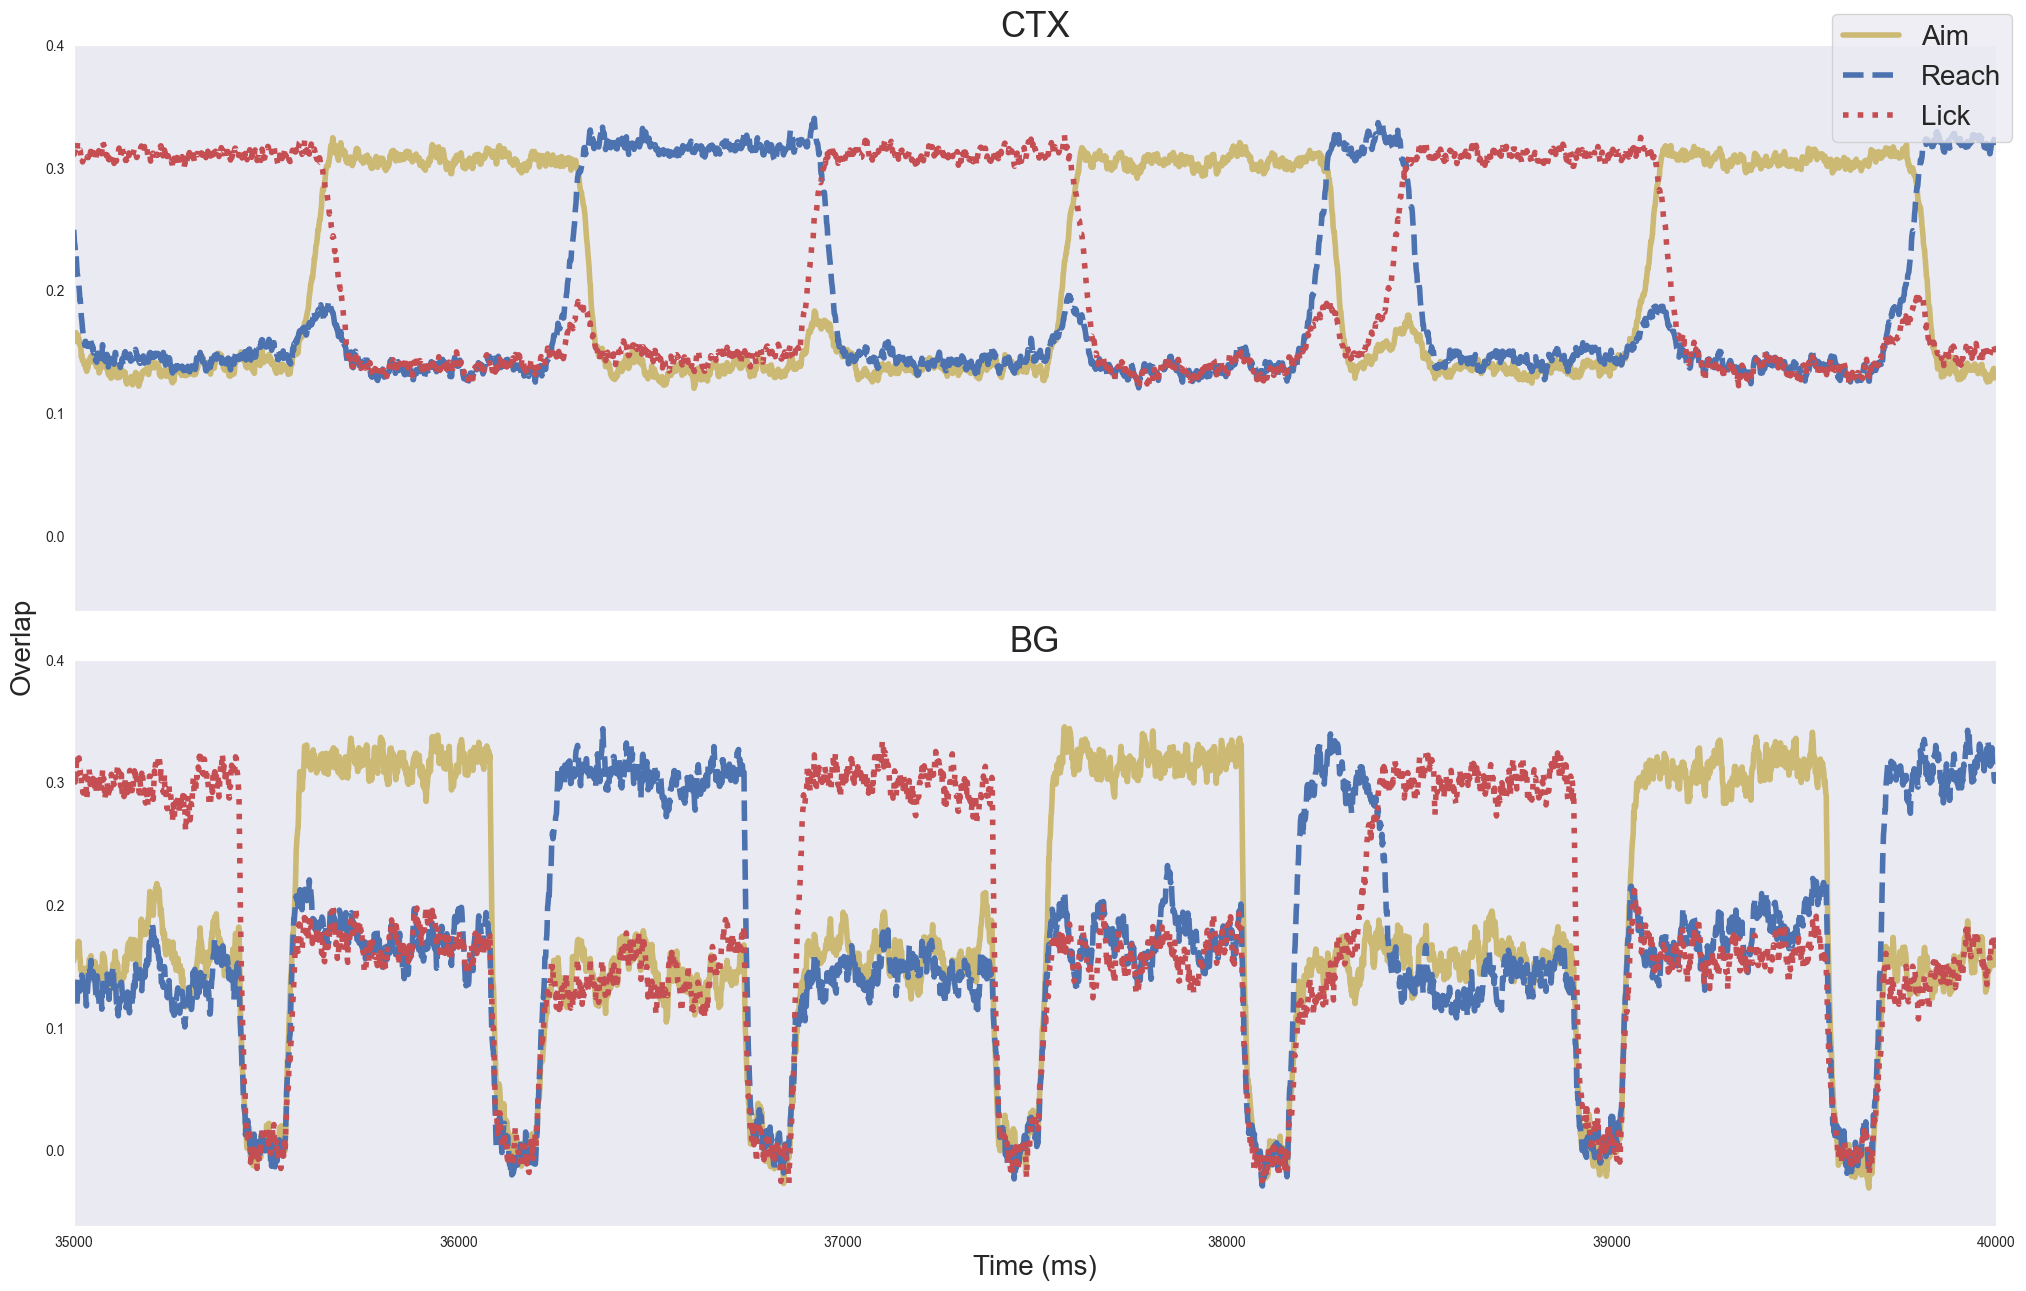

In [13]:
fig, axes = plt.subplots(2,1, sharex=True, sharey=True, tight_layout=True, figsize=(20,13))
axes[0].plot(overlaps_ctx[0], linestyle='solid', linewidth=4, color=colors[8])
axes[0].plot(overlaps_ctx[1], linestyle='dashed', linewidth=4, color=colors[0])
axes[0].plot(overlaps_ctx[2], linestyle='dotted', linewidth=4, color=colors[3])
axes[0].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[0].set_title("CTX", fontsize=25)
axes[1].plot(overlaps_bg[0], linestyle='solid', linewidth=4, color=colors[8])
axes[1].plot(overlaps_bg[1], linestyle='dashed', linewidth=4, color=colors[0])
axes[1].plot(overlaps_bg[2], linestyle='dotted', linewidth=4, color=colors[3])
axes[1].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[1].set_title("BG", fontsize=25)
axes[1].set_xlabel('Time (ms)', fontsize=20)
fig.text(-0.01, 0.5, 'Overlap', va='center', rotation='vertical', fontsize=20)
plt.setp(axes, xlim=(35000, 40000))
plt.figlegend(labels=['Aim', 'Reach', 'Lick'], fontsize=20)
plt.show()


In [8]:
np.savez('./output/learning4.npz', overlaps_ctx=overlaps_ctx, overlaps_bg=overlaps_bg)